In [ ]:
!pip install torchtext

In [6]:
import numpy as np
import pandas as pd

from torchtext.vocab import FastText
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Configuration

In [88]:
EPOCHS = 15
SEQ_SIZE = 45
BATCH_SIZE = 8
SEED = 0
EPOCHS = 10

In [89]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
set_seed(SEED)    

# Preprocessing

In [90]:
df = pd.read_csv('/content/drive/MyDrive/NLP/rus.tsv', sep='\t', encoding='utf8', names=['term', 'tag'])

In [91]:
df.head(20)

,term,tag
0,Губернатору,O
1,Подмосковья,B-GPE
2,прочат,O
3,скорую,O
4,отставку,O
5,Эксперты,O
6,считают,O
7,",",O
8,что,O
9,позиции,O


In [92]:
df.shape

(29131, 2)

In [93]:
df['tag'].unique()

array(['O', 'B-GPE', 'B-PERSON', 'I-PERSON', 'B-ORG', 'I-ORG', 'B-DATE',
       'I-DATE', 'I-GPE', 'B-QUANTITY', 'I-QUANTITY', 'B-NORP', 'B-LOC',
       'I-LOC', 'B-MONEY', 'I-MONEY', 'I-NORP', 'B-PERCENT', 'I-PERCENT',
       'B-CARDINAL', 'B-ORDINAL', 'I-CARDINAL', 'B-FAC', 'B-TIME',
       'I-TIME', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'I-FAC', 'B-LANGUAGE',
       'I-LANGUAGE', 'B-EVENT', 'I-EVENT', 'B-PRODUCT', 'I-PRODUCT'],
      dtype=object)

In [94]:
len(df['term'].unique())

9922

In [95]:
NUM_CLASSES = len(df['tag'].unique())

In [96]:
NUM_CLASSES

34

In [97]:
fasttext = FastText('ru')

In [98]:
fasttext.vectors

tensor([[ 0.0052,  0.2050,  0.0967,  ...,  0.1653, -0.4463,  0.1018],
        [-0.2809,  0.1918, -0.1590,  ..., -0.0307,  0.1229, -0.0039],
        [-0.1224,  0.0038,  0.0102,  ..., -0.0170,  0.0301,  0.2176],
        ...,
        [ 0.2376, -0.3427, -0.0080,  ...,  0.0823,  0.1635,  0.1587],
        [-0.1078,  0.4232, -0.1920,  ..., -0.2992, -0.1526, -0.2080],
        [ 0.4550, -0.0991,  0.1830,  ..., -0.1233,  0.0128,  0.0392]])

In [99]:
print(fasttext['капибара']) 

tensor([ 1.2314e-01,  2.2269e-01, -1.0699e-01, -9.5853e-02,  3.7299e-01,
        -1.1383e-01,  9.5147e-02, -3.7645e-01,  1.0970e-01,  2.2186e-01,
        -5.2696e-03, -6.7074e-01,  6.2589e-03,  8.4126e-02,  7.0765e-02,
        -3.0511e-01,  2.6337e-01, -2.6427e-01, -2.4342e-01,  3.3882e-01,
        -1.2817e-01, -3.8519e-01,  6.0133e-02, -6.0529e-01,  1.6741e-01,
         2.4429e-01, -1.8583e-01,  9.0952e-02,  1.2518e-01, -6.4293e-02,
         1.0541e-01, -2.5074e-01,  1.6875e-01, -3.8271e-01, -1.8477e-01,
        -1.5526e-01,  1.2449e-01,  1.8115e-02,  3.9182e-01, -2.8208e-01,
         3.3479e-01, -6.5976e-01, -3.5705e-01, -3.0068e-01, -1.1029e-01,
         3.7138e-02,  1.1719e-01, -1.0335e-01, -2.1815e-01,  1.8466e-01,
        -2.3377e-01, -2.3506e-01, -1.3686e-01,  1.1856e-02,  2.5046e-01,
         1.3268e-01, -4.0844e-01,  1.4613e-01,  9.9448e-02,  2.5069e-01,
         4.0357e-01,  1.6274e-01, -2.5884e-01,  7.3318e-01,  1.7849e-01,
         7.4381e-02, -1.9195e-01,  1.8391e-01,  1.9

In [100]:
fasttext.stoi['капибара']

483399

In [101]:
fasttext.vectors.shape

torch.Size([1888423, 300])

In [102]:
fasttext_vecs = torch.cat((fasttext.vectors,  torch.zeros((2, 300))))  # add idx for unknown and padding embedd

In [103]:
VOCAB_SIZE = fasttext_vecs.shape[0]
UNK_IDX = int(fasttext.vectors.shape[0])
PAD_IDX = int(fasttext.vectors.shape[0]) + 1


In [104]:
print(UNK_IDX)
print(PAD_IDX)

1888423
1888424


In [105]:
VOCAB_SIZE

1888425

In [106]:
df['term'] = df['term'].str.lower()
df['term'].head(10)

0    губернатору
1    подмосковья
2         прочат
3         скорую
4       отставку
5       эксперты
6        считают
7              ,
8            что
9        позиции
Name: term, dtype: object

In [107]:
id_to_tag = df['tag'].unique()
id_to_tag = dict(enumerate(id_to_tag))  # {0: 'O', 1: 'B-GPE', 2: 'B-PERSON', 3: 'I-PERSON',...}
tag_to_id = {v: k for k, v in id_to_tag.items()} 

In [108]:
tag_to_id

{'O': 0,
 'B-GPE': 1,
 'B-PERSON': 2,
 'I-PERSON': 3,
 'B-ORG': 4,
 'I-ORG': 5,
 'B-DATE': 6,
 'I-DATE': 7,
 'I-GPE': 8,
 'B-QUANTITY': 9,
 'I-QUANTITY': 10,
 'B-NORP': 11,
 'B-LOC': 12,
 'I-LOC': 13,
 'B-MONEY': 14,
 'I-MONEY': 15,
 'I-NORP': 16,
 'B-PERCENT': 17,
 'I-PERCENT': 18,
 'B-CARDINAL': 19,
 'B-ORDINAL': 20,
 'I-CARDINAL': 21,
 'B-FAC': 22,
 'B-TIME': 23,
 'I-TIME': 24,
 'B-WORK_OF_ART': 25,
 'I-WORK_OF_ART': 26,
 'I-FAC': 27,
 'B-LANGUAGE': 28,
 'I-LANGUAGE': 29,
 'B-EVENT': 30,
 'I-EVENT': 31,
 'B-PRODUCT': 32,
 'I-PRODUCT': 33}

In [109]:
df['tag_id'] = df['tag'].map(tag_to_id)
# split to lists
X_data = []
y_data = []
s = []
t = []
for index, row in df.iterrows():
    if row['term'] == '.':
        s.append(row['term'])
        t.append(row['tag_id'])
        X_data.append(s)
        y_data.append(t)
        s = []
        t = []
    else:
        s.append(row['term'])
        t.append(row['tag_id'])

In [110]:
print(X_data[0])
print(y_data[0])
s = []
for x in X_data:
  s.append(len(x))
s.sort(reverse=True)
s[0]  

['губернатору', 'подмосковья', 'прочат', 'скорую', 'отставку', 'эксперты', 'считают', ',', 'что', 'позиции', 'бориса', 'громова', 'пошатнулись', 'из-за', 'недавних', 'проблем', 'с', 'энергоснабжением', 'региона', '.']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0]


211

## Train test split

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, random_state=SEED)
print(len(X_train), len(X_test))

1173 294


## Trunkate sequences

In [112]:
def trunkate(txt):
    x = txt.copy()
    if len(x) >= SEQ_SIZE:
        return x[:SEQ_SIZE]
    if len(x) < SEQ_SIZE:
        while len(x) < SEQ_SIZE:
            x.append('<PAD>')
        return x[:SEQ_SIZE]

In [113]:
def trunkate_y(txt):
    x = txt.copy()
    if len(x) >= SEQ_SIZE:
        return x[:SEQ_SIZE]
    if len(x) < SEQ_SIZE:
        while len(x) < SEQ_SIZE:
            x.append(NUM_CLASSES) # target pad idx = num classes, bc we start from 0 [0,  NUM_CLASSES)
        return x[:SEQ_SIZE]

In [114]:
y_train_tr = [trunkate_y(txt) for txt in y_train]
y_test_tr = [trunkate_y(txt) for txt in y_test]

In [115]:
X_train_tr = [trunkate(txt) for txt in X_train]
X_test_tr = [trunkate(txt) for txt in X_test]

In [116]:
def seq_to_idx_list(txt):
    res = []
    for w in txt:
        if w == "<PAD>":
            res.append(PAD_IDX)
        elif w not in fasttext.stoi:
            res.append(UNK_IDX)
        else:
            res.append(fasttext.stoi[w]) 
    return res

In [117]:
X_train_idx = [seq_to_idx_list(seq) for seq in X_train_tr]
X_test_idx = [seq_to_idx_list(seq) for seq in X_test_tr]

## To tensor and data loader

In [118]:
train_ds = TensorDataset(torch.LongTensor(X_train_idx), torch.LongTensor(y_train_tr))
test_ds = TensorDataset(torch.LongTensor(X_test_idx), torch.LongTensor(y_test_tr))

In [119]:
train_dl = DataLoader(train_ds, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# Model

In [120]:
class NERModel(nn.Module):
  
    def __init__(self, hidden_dim, output_dim, embedding_dim=300, batch_first=True, drop_prob=0.2, num_layers=2):
        super(NERModel, self).__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(fasttext_vecs, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=batch_first, dropout=drop_prob)
        # self.linear = nn.Linear(hidden_dim, output_dim)
        self.linear1 = nn.Linear(hidden_dim, output_dim*2)
        self.batch_norm = nn.BatchNorm1d(SEQ_SIZE)
        self.linear2 = nn.Linear(output_dim*2, output_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, x, h, c):
        # text = [sent len, batch size]
        embedded = self.embedding(x)
        # output, hidden = self.rnn(embedded, h)
        output, hidden = self.rnn(embedded, (h, c))
        output = self.dropout(output)
        # output = self.linear(output) # one linear/dense
        output = self.linear1(output)
        output = self.batch_norm(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim), torch.zeros(self.num_layers, batch_size, self.hidden_dim)




# Train

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [122]:
model = NERModel(hidden_dim=128, output_dim=NUM_CLASSES, num_layers=1) #bs 8, hidden_dim 128, 1 layer, 5 epoch, dropout 0.2
print(model)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


NERModel(
  (embedding): Embedding(1888425, 300, padding_idx=1888424)
  (rnn): LSTM(300, 128, batch_first=True, dropout=0.2)
  (linear1): Linear(in_features=128, out_features=68, bias=True)
  (batch_norm): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=68, out_features=34, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [123]:
criterion = nn.CrossEntropyLoss(ignore_index=NUM_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [124]:
dataloaders = {'train': train_dl,
               'train_val': train_dl,
               'val': test_dl}

all_tr_loss = np.zeros(EPOCHS)
all_val_loss = np.zeros(EPOCHS)
best_loss_val = 99
for e in range(EPOCHS):
    for mode in ['train','train_val', 'val']:
        epoch_loss = {'train': 0.0, 'train_val': 0.0, 'val': 0.0}
        if mode == 'train':
            model.train()
        else:
            model.eval()
        # h0 =  model.init_hidden(BATCH_SIZE)
        h, c =  model.init_hidden(BATCH_SIZE)
        h = h.to(device)
        c = c.to(device)

        b_losses = []  # batch losses
        for batch_idx, batch in enumerate(dataloaders[mode]):
            input_ = batch[0].to(device)
            target = batch[1].to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(mode == 'train'):
                out, hidden = model(input_, h, c)
                out = out.contiguous().view(-1, out.size(2))  # shape (BATCH_SIZE * SEQ_SIZE, NUM_CLASSES)
                target = target.contiguous().view(-1)  # shape (BATCH_SIZE * SEQ_SIZE)
                loss = criterion(out, target)
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
            b_losses.append(loss.item())
        epoch_loss[mode] = np.mean(b_losses)
        # if epoch_loss['val'] < best_loss_val:
        #   best_loss_val = epoch_loss['val']
        #   torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/NER/lstm_best.pt')
    
    print(f"Epoch {e+1}", f"val loss ----- {epoch_loss['val']}")
    all_tr_loss[e] = epoch_loss['train_val']
    all_val_loss[e] = epoch_loss['val']

Epoch 1 val loss ----- 0.536096186687549
Epoch 2 val loss ----- 0.3468133815460735
Epoch 3 val loss ----- 0.29111598432064056
Epoch 4 val loss ----- 0.268701015247239
Epoch 5 val loss ----- 0.2588094046546353
Epoch 6 val loss ----- 0.2614656562606494
Epoch 7 val loss ----- 0.25900453473958707
Epoch 8 val loss ----- 0.2689796667546034
Epoch 9 val loss ----- 0.27580264759146506
Epoch 10 val loss ----- 0.2856797598716285


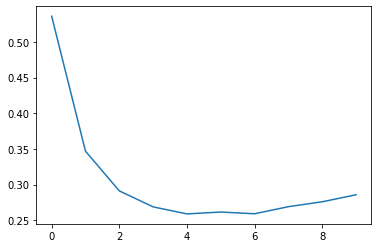

In [125]:
plt.plot(all_val_loss)
plt.show()

In [126]:
# model_best = NERModel(hidden_dim=128, output_dim=NUM_CLASSES, num_layers=1)
# model_best.load_state_dict(torch.load('/content/drive/MyDrive/NLP/NER/lstm_best.pt'))
# model_best = model_best.to(device)

In [127]:
def get_predict(txt_list: list, model):
    x = [txt_list]
    x = [trunkate(seq) for seq in x]
    x = [seq_to_idx_list(seq) for seq in x]
    x = [x[0] for i in range(BATCH_SIZE)]
    x = torch.LongTensor(x)

    model.eval()
    h, c =  model.init_hidden(BATCH_SIZE)
    h = h.to(device)
    c = c.to(device)
    input = x.to(device)
    with torch.set_grad_enabled(False): # we dont need grad on inference
        out, hidden = model(input, h, c)
    out = out.cpu()[0]
    sf = nn.Softmax(1)
    out = sf(out)
    out = torch.argmax(out, dim=1).numpy().tolist()
    out = out[:len(txt_list)]
    assert len(out) == len(txt_list)
    out = [id_to_tag[s] for s in out]
    out = pd.DataFrame(data=[txt_list, out], index=['term', 'tag']).transpose()
    return out

In [128]:
test = get_predict(X_test[12], model)
print(y_test[12])
test

[2, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 6, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0]


,term,tag
0,кан,B-PERSON
1,также,O
2,осудил,O
3,визит,O
4,на,O
5,острова,B-LOC
6,президента,O
7,россии,B-GPE
8,дмитрия,B-PERSON
9,медведева,I-PERSON


In [129]:
def ner_inference(model):
  while(True):
    test_text = input("Please enter example input: ")
    if test_text == 'quit':
      break
    test_text = test_text.lower().split(' ')
    test = get_predict(test_text, model)
    display(test)

In [131]:
ner_inference(model) 

Please enter example input: Пирогов на заседании ООН объявил о том, что он наелся пирогов


,term,tag
0,пирогов,B-PERSON
1,на,O
2,заседании,O
3,оон,B-ORG
4,объявил,O
5,о,O
6,"том,",O
7,что,O
8,он,O
9,наелся,O


Please enter example input: Мэр Новосибирской Области Анатолий Локоть укусил себя за локоть


,term,tag
0,мэр,O
1,новосибирской,B-GPE
2,области,I-GPE
3,анатолий,B-PERSON
4,локоть,I-PERSON
5,укусил,O
6,себя,O
7,за,O
8,локоть,O


Please enter example input: quit
